<a href="https://colab.research.google.com/github/ayanban011/Getting-Started_with_Pytorch/blob/main/Use_of_a_convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Convolutional Neural Network**




In [1]:
# downloading pytorchcv
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2022-07-03 07:27:25--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2022-07-03 07:27:26 (54.3 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [2]:
#load all dependencies and functions
!pip install torchinfo
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### **Convolutional filters**
Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.

They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:


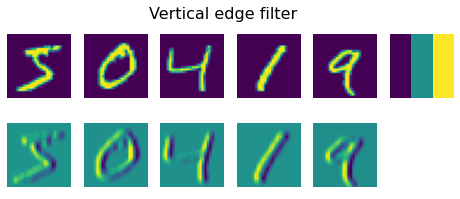

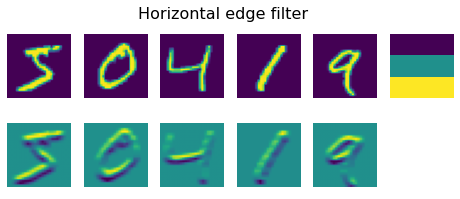

In [3]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

### **Convolutional layers**

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1. Color image has 3 channels (RGB).
* `out_channels` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used. The choice of filter size is usually chosen by experiment, that is by trying out different filter sizes and comparing resulting accuracy.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels). Here the result of each filter is represented by a different channel in the image (thus the first dimension 9 corresponds to the number of filters).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 

In [4]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        #self.conv = nn.Conv2d(in_channels=9, out_channels= 9, kernel_size=(3,3))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        #x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Epoch  0, Train acc=0.946, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.979, Val acc=0.976, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.986, Val acc=0.974, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.989, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.977, Train loss=0.000, Val loss=0.001


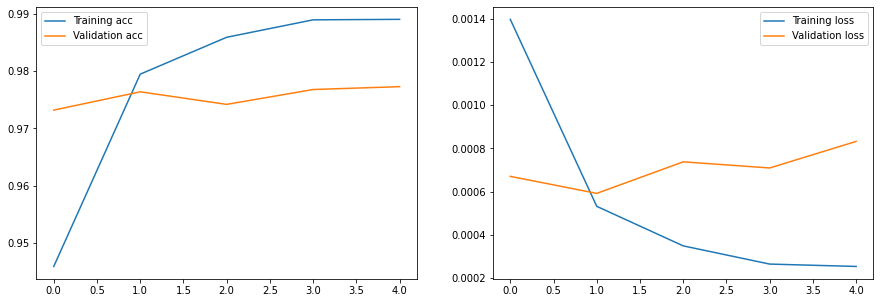

In [5]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

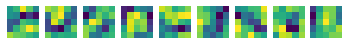

In [6]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

### **Pooling Layers**
First convolutional layers looks for primitive patterns, such as horizontal or vertical lines. Next level of convolutional layers on top of them look for higher-level patterns, such as primitive shapes. More convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. This creates a hierarchy of extracted patterns.

When doing so, we also need to apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within a sliding window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the pooling layers.

In [8]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 40, 3)
        self.fc = nn.Linear(160,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 160)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Conv2d: 1-5                            [1, 40, 2, 2]             7,240
├─Linear: 1-6                            [1, 10]                   1,610
Total params: 14,130
Trainable params: 14,130
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.12

Note a few things about the definition:
* Instead of using `Flatten` layer, we are flattening the tensor inside `forward` function using `view` function, which is similar to `reshape` function in numpy. Since flattening layer does not have trainable weights, it is not required that we create a separate layer instance within our class - we can just use a function from `torch.nn.functional` namespace.
* We use just one instance of pooling layer in our model, also because it does not contain any trainable parameters, and thus one instance can be effectively reused.
* The number of trainable parameters (~8.5K) is dramatically smaller than in previous cases (80K in Perceptron, 50K in one-layer CNN). This happens because convolutional layers in general have few parameters, independent of the input image size. Also, due to pooling, dimensionality of the image is significantly reduced before applying final dense layer. Small number of parameters have positive impact on our models, because it helps to prevent overfitting even on smaller dataset sizes.

In [9]:
hist = train(net,train_loader,test_loader,epochs=20)

Epoch  0, Train acc=0.947, Val acc=0.975, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.979, Val acc=0.984, Train loss=0.001, Val loss=0.000
Epoch  2, Train acc=0.984, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.985, Val acc=0.980, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.984, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  5, Train acc=0.984, Val acc=0.983, Train loss=0.000, Val loss=0.001
Epoch  6, Train acc=0.985, Val acc=0.985, Train loss=0.000, Val loss=0.000
Epoch  7, Train acc=0.987, Val acc=0.988, Train loss=0.000, Val loss=0.000
Epoch  8, Train acc=0.987, Val acc=0.975, Train loss=0.000, Val loss=0.001
Epoch  9, Train acc=0.988, Val acc=0.986, Train loss=0.000, Val loss=0.001
Epoch 10, Train acc=0.987, Val acc=0.986, Train loss=0.000, Val loss=0.001
Epoch 11, Train acc=0.987, Val acc=0.983, Train loss=0.000, Val loss=0.001
Epoch 12, Train acc=0.988, Val acc=0.985, Train loss=0.000, Val loss=0.001
Epoch 13, Train acc=0.988

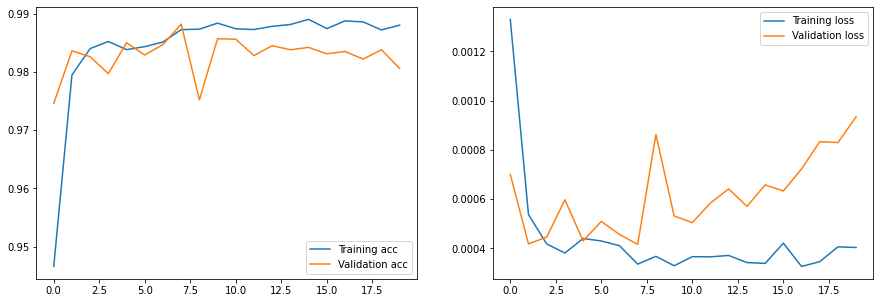

In [10]:
plot_results(hist)

IndexError: ignored

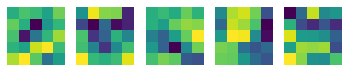

In [15]:
fig,ax = plt.subplots(1,5)
with torch.no_grad():
    p = next(net.conv1.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

### **Playing with real images from the CIFAR-10 dataset**
It contains 60k 32x32 color images, divided into 10 classes.

In [16]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


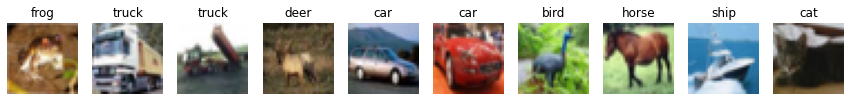

In [17]:
display_dataset(trainset,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above. However, since all images are color, input tensor size is $3\times32\times32$, and the $5\times5$ convolutional filter is applied across color dimension as well - meaning that the size of convolution kernel matrix is $3\times5\times5$. 

We also do one more simplification to this model - we do not use `log_softmax` as output activation function, and just return the output of last fully-connected layer. In this case we can just use `CrossEntropyLoss` loss function to optimize the model.

In [20]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

lenet = LeNet()

summary(lenet,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [21]:
opt = torch.optim.SGD(net.parameters(),lr=0.0001,momentum=0.7)
hist = train(lenet, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.100, Val acc=0.100, Train loss=0.165, Val loss=0.165
Epoch  1, Train acc=0.100, Val acc=0.100, Train loss=0.165, Val loss=0.165
Epoch  2, Train acc=0.100, Val acc=0.100, Train loss=0.165, Val loss=0.165


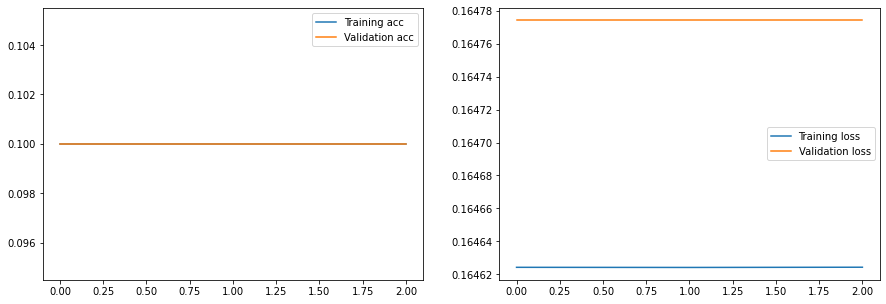

In [22]:
plot_results(hist)